# Cost-Sensitive Fraud Detection System


— Define the business problem (cost-sensitive)

- Fraud = positive class (1), legit = 0

- Choose costs (example you can justify):
    - False Negative (miss fraud) cost = $500 (chargeback + fees + loss)

    - False Positive (flag legit) cost = $5 (support + friction)

- Goal: minimize expected financial loss from fraudulent transactions using machine learning and threshold optimization, not maximize accuracy. Final result: 87% reduction in expected fraud-related cost.

#Setup

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [2]:
from google.colab import files
files.upload()   # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cyril26","key":"991e9a53346c70d0b01538a53703c552"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Download dataset

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.40GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


Load Data

In [5]:
df = pd.read_csv("creditcard.csv")

print("Shape:", df.shape)
df.head()


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Basic Data Inspection

In [8]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


checking for missing values

In [9]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Check Class Imbalance

Fraud rate: 0.001727485630620034


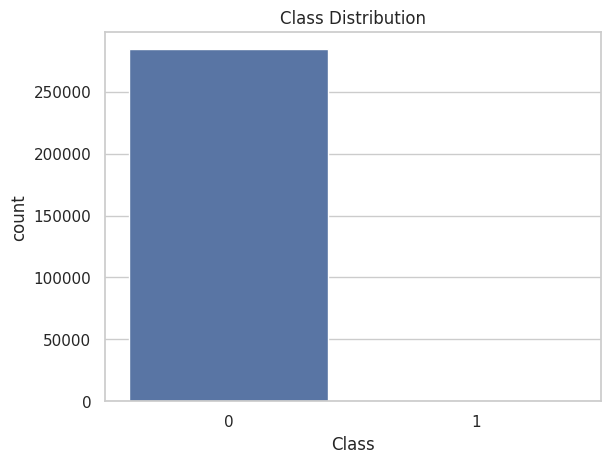

In [10]:
fraud_rate = df["Class"].mean()
print("Fraud rate:", fraud_rate)

sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.show()


This is extremely imbalanece since we have 0.17% fraud.

Feature Scaling
- scale Amount using StandardScalar

In [11]:
scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])
df = df.drop(columns=["Amount"])


# Train/Validation/Test Split

We use 3-way split for proper threshold tuning.

- 60% train
- 20% validation
- 20% test

In [13]:
X = df.drop(columns=["Class"])
y = df["Class"]

# First split: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# Second split: validation vs test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape)
print("Valid:", X_valid.shape)
print("Test :", X_test.shape)


Train: (170884, 30)
Valid: (56961, 30)
Test : (56962, 30)


# Baseline Model

We start with dummy classifier (predict all non-fraud). This shows how misleading accuracy is.

In [14]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

probs_valid = dummy.predict_proba(X_valid)[:, 1]
preds_valid = dummy.predict(X_valid)


# Metrics function

In [16]:
def evaluate_model(y_true, probs, threshold=0.5):
    preds = (probs >= threshold).astype(int)

    print("ROC-AUC:", roc_auc_score(y_true, probs))
    print("PR-AUC :", average_precision_score(y_true, probs))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, preds))
    print("\nClassification Report:")
    print(classification_report(y_true, preds))

evaluate_model(y_valid, probs_valid)


ROC-AUC: 0.5
PR-AUC : 0.0017204754130018785

Confusion Matrix:
[[56863     0]
 [   98     0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Define Business Cost Function

Example costs:

- False Negative (miss fraud) = $500

- False Positive (flag legit) = $5

In [17]:
COST_FN = 500
COST_FP = 5

Cost calculator

In [19]:
def compute_cost(y_true, probs, threshold):
    preds = (probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    total_cost = fp * COST_FP + fn * COST_FN
    return total_cost


cost_dummy = compute_cost(y_valid, probs_valid, threshold=0.5)
print("Baseline cost:", cost_dummy)


Baseline cost: 49000


Function for visualizing Cost vs Threshold

In [20]:
def plot_cost_curve(y_true, probs):
    thresholds = np.linspace(0, 1, 200)
    costs = [compute_cost(y_true, probs, t) for t in thresholds]

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, costs)
    plt.xlabel("Threshold")
    plt.ylabel("Total Cost")
    plt.title("Cost vs Threshold")
    plt.show()


# Train Logistic Regression (with class weights)

We used Logistic Regression because of its interpretable, strong baseline for tabular data, handles probability estimation well, and works great with cost-based thresholds.

In [21]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    class_weight="balanced",   # important for imbalance
    max_iter=1000,
    random_state=42
)

log_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Predict Probabilities (Validation Set)

We optimize threshold using validation data only.

In [22]:
log_probs_valid = log_model.predict_proba(X_valid)[:, 1]


# Evaluate Default Threshold (0.5)

This is NOT optimal — but we check it for comparison.

In [23]:
print("Logistic Regression — default threshold 0.5")
evaluate_model(y_valid, log_probs_valid, threshold=0.5)

default_cost = compute_cost(y_valid, log_probs_valid, threshold=0.5)
print("Cost at threshold 0.5:", default_cost)


Logistic Regression — default threshold 0.5
ROC-AUC: 0.9791223947856054
PR-AUC : 0.6747212726817328

Confusion Matrix:
[[55652  1211]
 [   13    85]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.07      0.87      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.92      0.56     56961
weighted avg       1.00      0.98      0.99     56961

Cost at threshold 0.5: 12555


# Find Cost-Optimal Threshold

We test many thresholds and pick the one minimizing cost.

In [24]:
# Threshold search function

def find_optimal_threshold(y_true, probs):
    thresholds = np.linspace(0, 1, 200)
    costs = [compute_cost(y_true, probs, t) for t in thresholds]

    best_idx = np.argmin(costs)
    best_threshold = thresholds[best_idx]
    best_cost = costs[best_idx]

    return best_threshold, best_cost, thresholds, costs


optimization

In [25]:
opt_threshold, opt_cost, thresholds, costs = find_optimal_threshold(
    y_valid, log_probs_valid
)

print("Optimal threshold:", opt_threshold)
print("Minimum validation cost:", opt_cost)


Optimal threshold: 0.8844221105527639
Minimum validation cost: 8800


Visualize Cost Curve

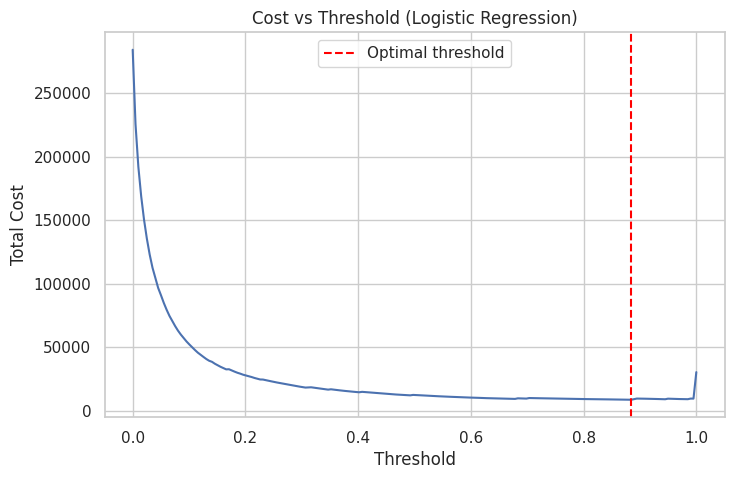

In [26]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, costs)
plt.axvline(opt_threshold, color="red", linestyle="--", label="Optimal threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost vs Threshold (Logistic Regression)")
plt.legend()
plt.show()


Evaluate Model at Optimal Threshold (Validation)

In [27]:
print("Logistic Regression — cost-optimal threshold")
evaluate_model(y_valid, log_probs_valid, threshold=opt_threshold)

print("Cost at optimal threshold:", opt_cost)


Logistic Regression — cost-optimal threshold
ROC-AUC: 0.9791223947856054
PR-AUC : 0.6747212726817328

Confusion Matrix:
[[56603   260]
 [   15    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.24      0.85      0.38        98

    accuracy                           1.00     56961
   macro avg       0.62      0.92      0.69     56961
weighted avg       1.00      1.00      1.00     56961

Cost at optimal threshold: 8800


Final Evaluation on TEST Set (Only Once)

Important rule:

- Threshold chosen from validation
- Test set used once for final performance

In [29]:
#Predict test probabilities

log_probs_test = log_model.predict_proba(X_test)[:, 1]


# Evaluate final model
print("FINAL TEST PERFORMANCE — Logistic Regression")

evaluate_model(y_test, log_probs_test, threshold=opt_threshold)

final_test_cost = compute_cost(y_test, log_probs_test, opt_threshold)
print("Final test cost:", final_test_cost)


FINAL TEST PERFORMANCE — Logistic Regression
ROC-AUC: 0.9676534260886125
PR-AUC : 0.7421697889092329

Confusion Matrix:
[[56585   278]
 [   11    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.24      0.89      0.38        99

    accuracy                           0.99     56962
   macro avg       0.62      0.94      0.69     56962
weighted avg       1.00      0.99      1.00     56962

Final test cost: 6890


Compare Against Baseline

In [30]:
print("Dummy cost:", cost_dummy)
print("Logistic cost:", final_test_cost)

improvement = (cost_dummy - final_test_cost) / cost_dummy * 100
print("Cost reduction (%):", improvement)


Dummy cost: 49000
Logistic cost: 6890
Cost reduction (%): 85.93877551020408


# Train a Tree Model (Random Forest)


Train Random Forest (with imbalance handling): Random Forest doesn’t output great probabilities by default, but it’s a solid model to compare.

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       n_estimators=400, n_jobs=-1, random_state=42)

Predict probabilities (validation + test)

In [32]:
rf_probs_valid = rf_model.predict_proba(X_valid)[:, 1]
rf_probs_test  = rf_model.predict_proba(X_test)[:, 1]


Find cost-optimal threshold (validation)

In [33]:
rf_opt_threshold, rf_opt_cost, rf_thresholds, rf_costs = find_optimal_threshold(y_valid, rf_probs_valid)

print("RF optimal threshold:", rf_opt_threshold)
print("RF min validation cost:", rf_opt_cost)


RF optimal threshold: 0.07035175879396985
RF min validation cost: 7720


Plot RF cost curve

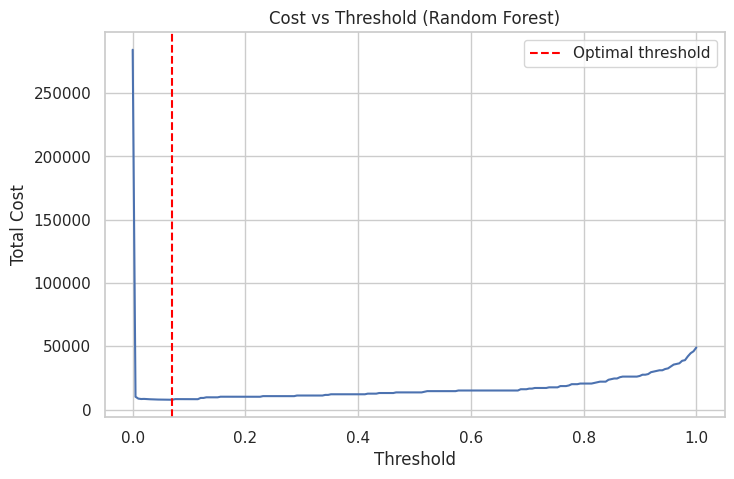

In [34]:
plt.figure(figsize=(8,5))
plt.plot(rf_thresholds, rf_costs)
plt.axvline(rf_opt_threshold, color="red", linestyle="--", label="Optimal threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost vs Threshold (Random Forest)")
plt.legend()
plt.show()


Final evaluation on TEST using the validation-chosen threshold

In [35]:
print("RANDOM FOREST — FINAL TEST PERFORMANCE")
evaluate_model(y_test, rf_probs_test, threshold=rf_opt_threshold)

rf_test_cost = compute_cost(y_test, rf_probs_test, rf_opt_threshold)
print("RF final test cost:", rf_test_cost)


RANDOM FOREST — FINAL TEST PERFORMANCE
ROC-AUC: 0.9759880961453162
PR-AUC : 0.8755539670280045

Confusion Matrix:
[[56822    41]
 [   12    87]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.68      0.88      0.77        99

    accuracy                           1.00     56962
   macro avg       0.84      0.94      0.88     56962
weighted avg       1.00      1.00      1.00     56962

RF final test cost: 6205


Compare Logistic vs RF (Cost-first)

In [45]:
results = pd.DataFrame({
    "Model": ["Dummy", "LogReg", "RandomForest"],
    "Threshold": [0.5, opt_threshold, rf_opt_threshold],
    "TestCost": [cost_dummy, final_test_cost, rf_test_cost],
    "TestPR_AUC": [
        average_precision_score(y_test, dummy.predict_proba(X_test)[:,1]),
        average_precision_score(y_test, log_probs_test),
        average_precision_score(y_test, rf_probs_test),
    ],
    "TestROC_AUC": [
        roc_auc_score(y_test, dummy.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, log_probs_test),
        roc_auc_score(y_test, rf_probs_test),
    ],
})

results.sort_values("TestCost")


,Model,Threshold,TestCost,TestPR_AUC,TestROC_AUC
2,RandomForest,0.070352,6205,0.875554,0.975988
1,LogReg,0.884422,6890,0.742170,0.967653
0,Dummy,0.500000,49000,0.001738,0.500000


The model with lowest TestCost is the winner.

In [37]:
best_model_name = results.sort_values("TestCost").iloc[0]["Model"]
best_model_name


'RandomForest'

# Explainability (Feature Importance)

RF Feature Importance (fast, no SHAP yet)

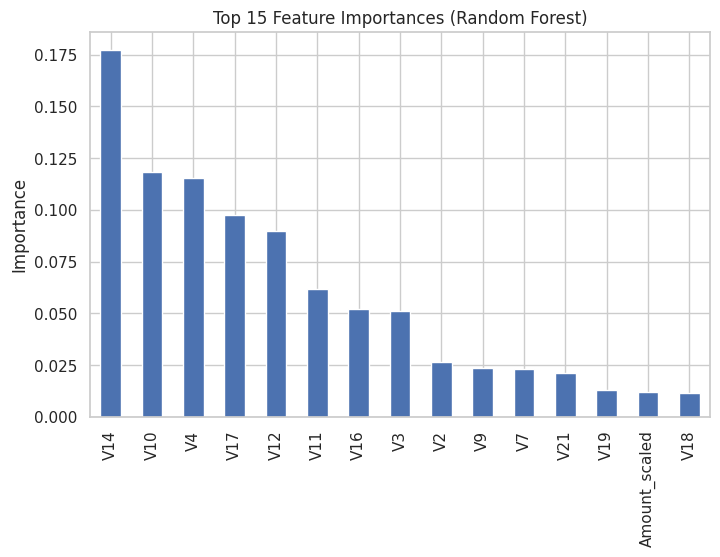

,0
V14,0.177148
V10,0.118158
V4,0.115607
V17,0.097541
V12,0.089859
V11,0.061801
V16,0.052386
V3,0.050987
V2,0.026328
V9,0.023416


In [38]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.show()

importances.head(15)


# Build a Simple Fraud Operations Policy (Approve / Review / Block)

This is a big differentiator. You’ll define two thresholds:

- Approve if prob < t_low
- Manual review if t_low ≤ prob < t_high
- Block if prob ≥ t_high

We will pick t_high to minimize cost (block threshold), and set t_low to control review volume.

Choose policy thresholds: Use the best model (RF model) probabilities on validation.

In [39]:
probs_valid_best = rf_probs_valid
probs_test_best = rf_probs_test
t_high = rf_opt_threshold


Next, we set a low threshold that sends ~5% to review (you can adjust).

In [40]:
review_rate = 0.05
t_low = np.quantile(probs_valid_best, 1 - review_rate)

print("t_low:", t_low)
print("t_high:", t_high)
print("Review fraction on valid:", (probs_valid_best >= t_low).mean())


t_low: 0.0024978548942089468
t_high: 0.07035175879396985
Review fraction on valid: 0.05006934569266691


Policy simulation

We assume:

- Block decisions: predicted fraud => if legit, that’s a FP (cost = COST_FP)
- Review decisions: add a “review cost” per transaction
- Approve: no action cost, but fraud can slip through => FN cost

Set review cost:

In [41]:
COST_REVIEW = 2  # example operational cost per review


Policy cost function:

In [43]:
def compute_policy_cost(y_true, probs, t_low, t_high):
    # actions: 0=approve, 1=review, 2=block
    actions = np.zeros_like(probs, dtype=int)
    actions[probs >= t_low] = 1
    actions[probs >= t_high] = 2

    # Approve: fraud becomes FN
    approve_mask = actions == 0
    fn = ((y_true == 1) & approve_mask).sum()

    # Block: legit becomes FP
    block_mask = actions == 2
    fp = ((y_true == 0) & block_mask).sum()

    # Review: operational cost (assume review catches fraud perfectly for simplicity)
    review_mask = actions == 1
    n_review = review_mask.sum()

    total_cost = fn * COST_FN + fp * COST_FP + n_review * COST_REVIEW
    return total_cost, fn, fp, n_review

# Run on validation:
policy_cost_valid, fn_v, fp_v, nrev_v = compute_policy_cost(y_valid.values, probs_valid_best, t_low, t_high)
print("Policy VALID cost:", policy_cost_valid)
print("FN:", fn_v, "FP:", fp_v, "Review:", nrev_v)

# Run on test:
policy_cost_test, fn_t, fp_t, nrev_t = compute_policy_cost(y_test.values, probs_test_best, t_low, t_high)
print("Policy TEST cost:", policy_cost_test)
print("FN:", fn_t, "FP:", fp_t, "Review:", nrev_t)




Policy VALID cost: 10670
FN: 10 FP: 44 Review: 2725
Policy TEST cost: 7953
FN: 5 FP: 41 Review: 2624


# Summary Figure

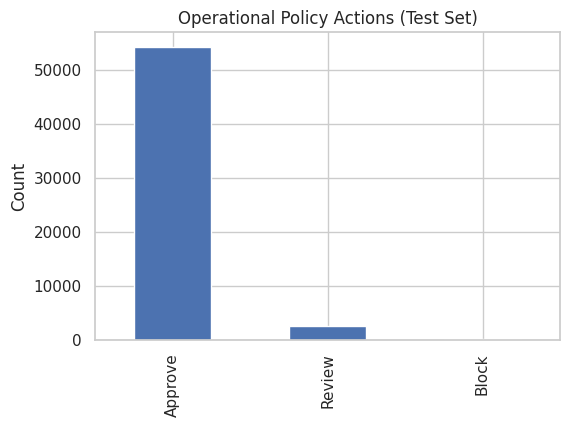

In [44]:
labels = ["Approve", "Review", "Block"]
actions_test = np.zeros_like(probs_test_best, dtype=int)
actions_test[probs_test_best >= t_low] = 1
actions_test[probs_test_best >= t_high] = 2

counts = pd.Series(actions_test).value_counts().reindex([0,1,2], fill_value=0)
counts.index = labels

plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Operational Policy Actions (Test Set)")
plt.ylabel("Count")
plt.show()
